# SPOmiAlign 图像处理与对齐流程

本 Notebook 实现了从 H5AD 栅格化到多阶段图像配准（NISS -> CCF）的完整流程。

## 1. 导入库与环境配置

In [2]:
import os 
import cv2 
import sys 
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# 在 Notebook 中，__file__通常未定义，我们使用相对路径或当前目录
# 假设 Notebook 位于脚本原本所在的目录
sys.path.append("../../SPOmiAlign")

try:
    from roma import align_and_process_images
    from data_preprocessing import rasterize_h5ad_to_image
    print("✅ 成功导入自定义模块")
except ImportError as e:
    print(f"❌ 导入失败: {e}")
    print("请检查 sys.path.append 的路径是否正确指向了 SPOmiAlign 库")

✅ 成功导入自定义模块


## 2. 路径定义与初始化

In [3]:
DATA_DIR = "../../SPOmiAlign_Repro"
SAVE_DIR = "../../output"

# 输入文件路径
h5ad_path = os.path.join(DATA_DIR, "data_preprocessing", "Puck_Num_43.h5ad")
target_image_path = os.path.join(DATA_DIR, "output_reference", "CCF_100048576_273.png")
niss_image_path = os.path.join(DATA_DIR, "output_niss", "niss_40.png")

# 输出目录设置
SAVE_PATH = os.path.join(SAVE_DIR, "h5ad_2_img", "PUCK43")
os.makedirs(SAVE_PATH, exist_ok=True)

print(f"📂 工作目录已准备就绪: {os.path.abspath(SAVE_PATH)}")

📂 工作目录已准备就绪: /data/Newdisk/Bigmodel/zxm/Match/RoMa-main/RoMa-main/20251226/Code/output/h5ad_2_img/PUCK43


## 3. 文件存在性验证

In [4]:
files_to_check = {
    "H5AD 数据": h5ad_path,
    "目标参考图像": target_image_path,
    "Nissl 图像": niss_image_path
}

print("\n🔍 正在检查输入文件...")
missing_files = []

for name, path in files_to_check.items():
    if os.path.exists(path):
        file_size = os.path.getsize(path) / (1024 * 1024)  # MB
        print(f"✅ {name} 已找到: {os.path.basename(path)} ({file_size:.2f} MB)")
    else:
        print(f"❌ {name} 不存在: {os.path.abspath(path)}")
        missing_files.append(path)

if missing_files:
    print("\n⚠️ 程序终止：请确保所有输入文件路径正确。")
    # 在 Notebook 中不建议直接 sys.exit()，这会杀死内核
    raise FileNotFoundError("缺失必要文件，请检查路径。")
else:
    print("🚀 所有文件准备就绪，准备开始处理。\n" + "-"*30)


🔍 正在检查输入文件...
✅ H5AD 数据 已找到: Puck_Num_43.h5ad (205.02 MB)
✅ 目标参考图像 已找到: CCF_100048576_273.png (1.57 MB)
✅ Nissl 图像 已找到: niss_40.png (0.85 MB)
🚀 所有文件准备就绪，准备开始处理。
------------------------------


## 4. 步骤一：H5AD 转化成图像

🚀 步骤一 H5ad转化成图像。
------------------------------
✅ PNG 已保存：../../output/h5ad_2_img/PUCK43/Gen_img_PUCK43.png（4386×5023，background=black，shape=circle，radius=5）
✅ 生成图像: ../../output/h5ad_2_img/PUCK43/Gen_img_PUCK43.png


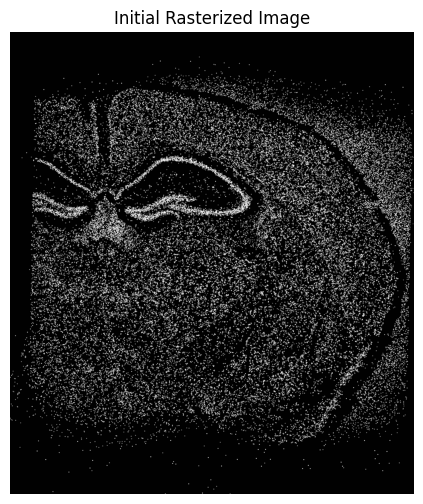

In [5]:
print("🚀 步骤一 H5ad转化成图像。\n" + "-"*30)
Gen_img_path = os.path.join(SAVE_PATH, "Gen_img_PUCK43.png")

_, origin = rasterize_h5ad_to_image(
    input_h5ad=h5ad_path,
    output_png=Gen_img_path,
    x_obs_col="Raw_Slideseq_X",
    y_obs_col="Raw_Slideseq_Y",
    # intensity_mode="obs_col",
    intensity_obs_col="nFeature_Spatial",
    intensity_log_transform=True,   # nFeature 计数建议 log1p
    threshold_percentile=80,        # 80 分位筛点
    background="black",
    point_shape="circle",
    radius=5,
    enhance=True,                  
    rotate=90,
    scale=1.0,
)

print(f"✅ 生成图像: {Gen_img_path}")
# 简单的内联显示
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(cv2.imread(Gen_img_path), cv2.COLOR_BGR2RGB))
plt.title("Initial Rasterized Image")
plt.axis('off')
plt.show()

## 5. 步骤二：将 H5AD 图像与 Nissl 图像对齐

🚀 步骤二 将h5ad图像和niss图像对齐。
------------------------------
Using device: cuda:0


2026-01-16 22:03:37.376 | INFO     | romatch.models.model_zoo.roma_models:roma_model:61 - Using coarse resolution (560, 560), and upsample res (864, 1152)


Running RoMa matching...
Estimating affine+bspline transform...
Warping images...
Padding fill color (from 10,10): [1, 1, 1]
Processing H5AD coordinates...
Raw_Slideseq_X Raw_Slideseq_Y
🔄 Applying manual pre-transform: rotate=90.0°, scale=1.0
⚠️ Removing '_index' column from adata.var...
⚠️ Removing '_index' column from adata.raw.var...
✅ Saved transformed H5AD to ../../output/h5ad_2_img/PUCK43/alignment_with_niss/transformed.h5ad


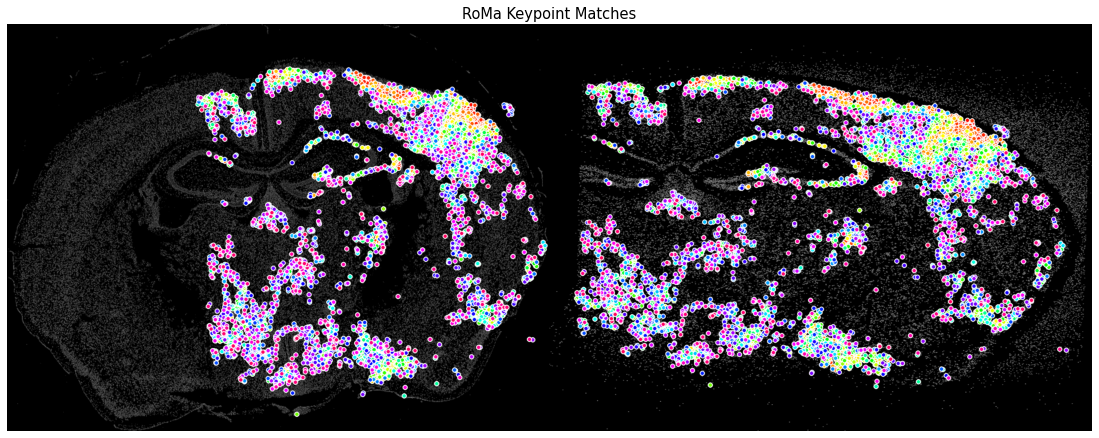

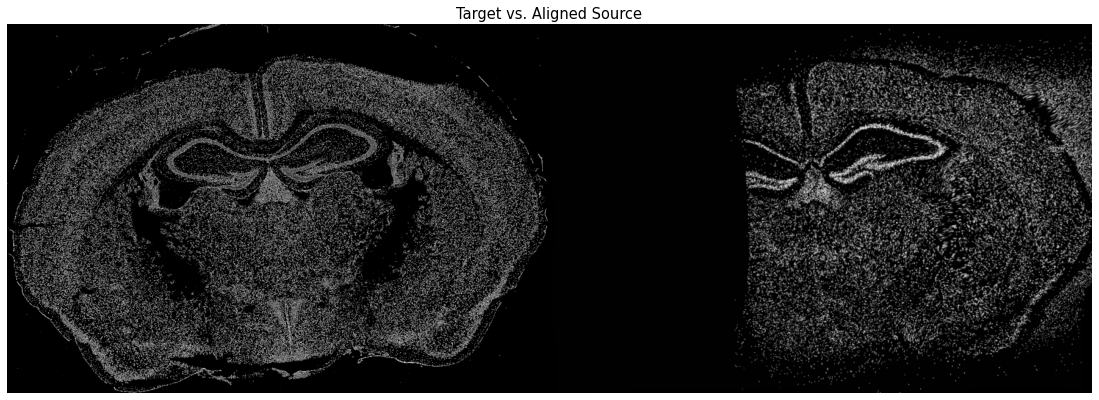

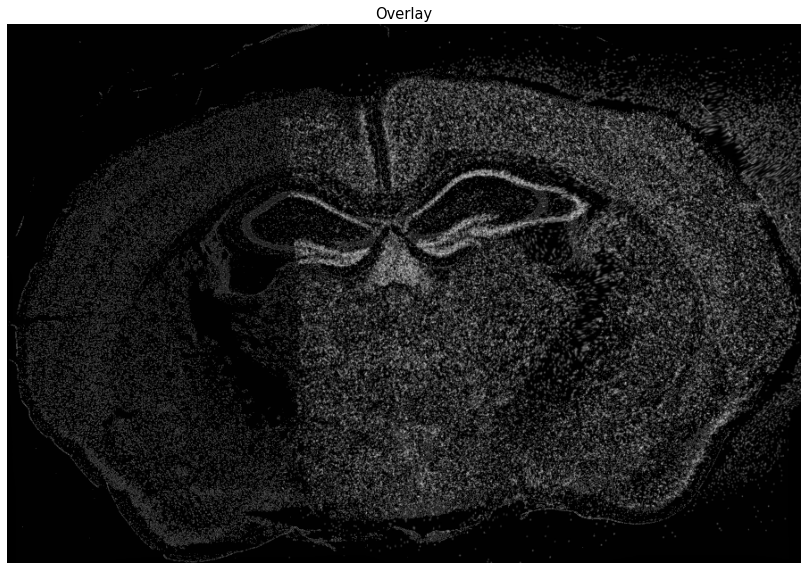

Alignment runtime: 11.3396 seconds
Done. Results saved to ../../output/h5ad_2_img/PUCK43/alignment_with_niss
✅ PNG 已保存：../../output/h5ad_2_img/PUCK43/alignment_with_niss/transformed_h5ad.png（917×662，background=black，shape=circle，radius=2）
✅ 步骤二完成


In [6]:
print("🚀 步骤二 将h5ad图像和niss图像对齐。\n" + "-"*30)

save_path_alignment_with_niss = os.path.join(SAVE_PATH, "alignment_with_niss")
transformed_with_niss_h5ad_path = os.path.join(save_path_alignment_with_niss, "transformed.h5ad")
transformed_with_niss_h5ad_img_path = os.path.join(save_path_alignment_with_niss, "transformed_h5ad.png")
img2_warpped_with_niss = os.path.join(save_path_alignment_with_niss, "aligned_source_img2.png")

align_and_process_images(
    img1_path=niss_image_path, 
    img2_path=Gen_img_path, 
    h5ad_path=h5ad_path,  
    method='affine+bspline', 
    output_dir=save_path_alignment_with_niss,     
    x_obs_col="Raw_Slideseq_X",            
    y_obs_col="Raw_Slideseq_Y",
    # === 新增参数 ===
    rotate=90.0,
    scale=1.0,
    origin=origin
)

# 对齐后重新栅格化
rasterize_h5ad_to_image(
    input_h5ad=transformed_with_niss_h5ad_path,
    output_png=transformed_with_niss_h5ad_img_path,
    x_obs_col="Raw_Slideseq_X",
    y_obs_col="Raw_Slideseq_Y",
    # intensity_mode="obs_col",
    intensity_obs_col="nFeature_Spatial",
    intensity_log_transform=True,   # nFeature 计数建议 log1p
    threshold_percentile=80,        # 80 分位筛点
    background="black",
    point_shape="circle",
    radius=2,
    enhance=True,                  
    rotate=0.0,
    scale=1.0,
)

print("✅ 步骤二完成")

## 6. 步骤三：将 H5AD 图像与 CCF (Target) 图像对齐

🚀 步骤三 将h5ad图像和ccf(target)图像对齐。
------------------------------
Using device: cuda:0


2026-01-16 22:03:56.036 | INFO     | romatch.models.model_zoo.roma_models:roma_model:61 - Using coarse resolution (560, 560), and upsample res (864, 1152)


Running RoMa matching...
Estimating affine+bspline transform...
Warping images...
Padding fill color (from 10,10): [0, 0, 0]
Processing H5AD coordinates...
Raw_Slideseq_X Raw_Slideseq_Y
✅ Saved transformed H5AD to ../../output/h5ad_2_img/PUCK43/alignment_with_ccf/transformed.h5ad


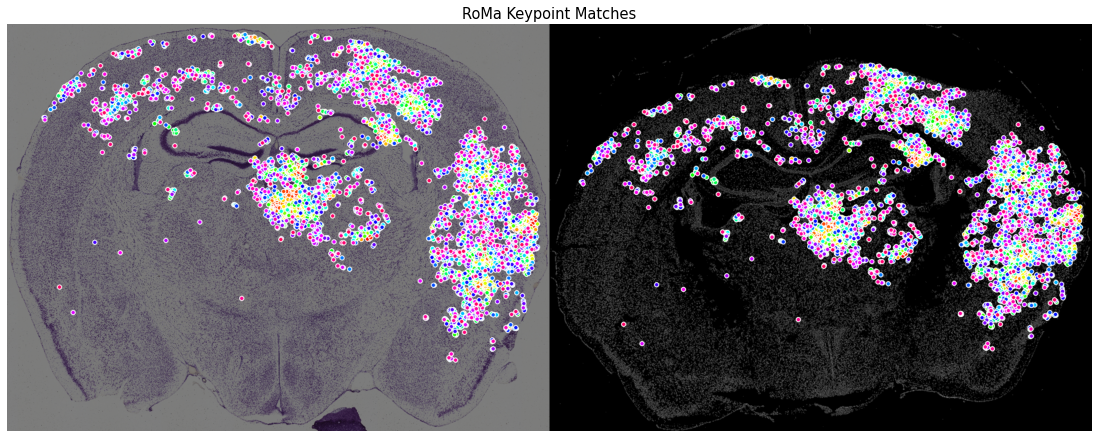

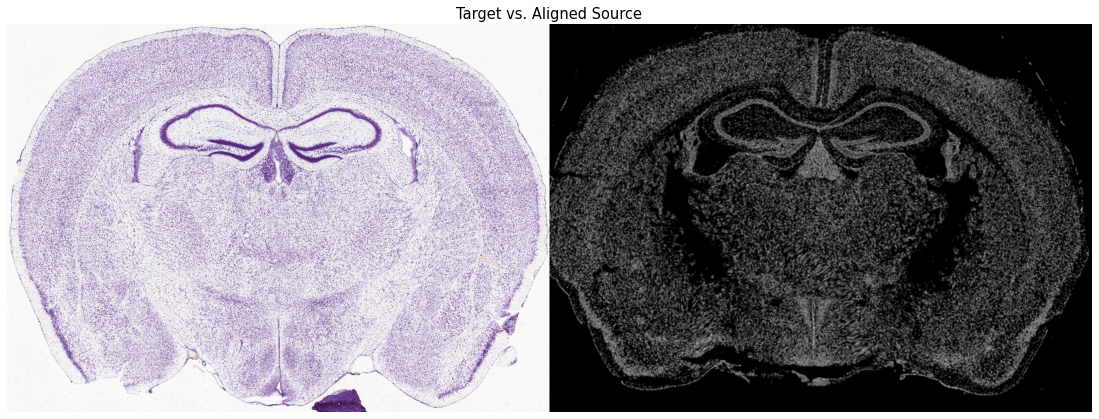

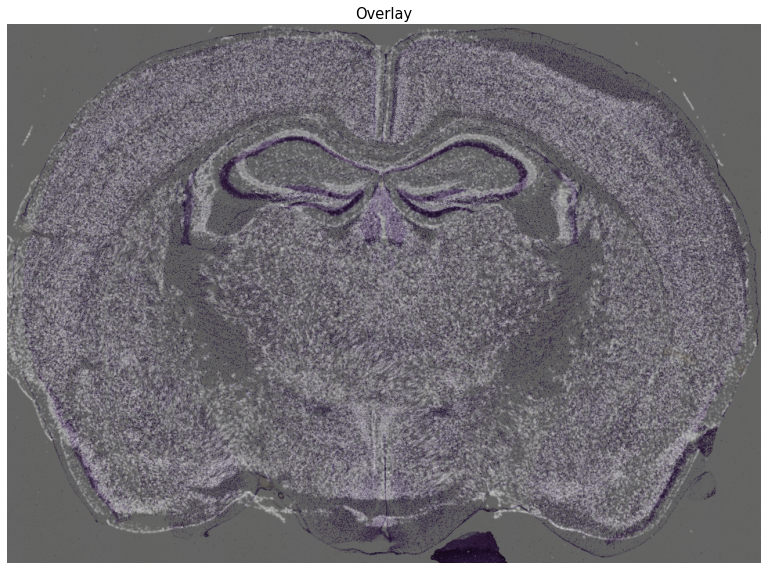

Alignment runtime: 6.5176 seconds
Done. Results saved to ../../output/h5ad_2_img/PUCK43/alignment_with_ccf
✅ PNG 已保存：../../output/h5ad_2_img/PUCK43/alignment_with_ccf/transformed_h5ad.png（1033×715，background=black，shape=circle，radius=2）
✅ 步骤三完成


In [7]:
print("🚀 步骤三 将h5ad图像和ccf(target)图像对齐。\n" + "-"*30)

save_path_alignment_with_ccf = os.path.join(SAVE_PATH, "alignment_with_ccf")
transformed_with_ccf_h5ad_path = os.path.join(save_path_alignment_with_ccf, "transformed.h5ad")
transformed_with_ccf_h5ad_img_path = os.path.join(save_path_alignment_with_ccf, "transformed_h5ad.png")

# 注意：这里输入的是上一步（NISS对齐）的输出结果
align_and_process_images(
    img1_path=target_image_path, 
    img2_path=niss_image_path, 
    h5ad_path=transformed_with_niss_h5ad_path,  
    method='affine+bspline', 
    output_dir=save_path_alignment_with_ccf,     
    x_obs_col="Raw_Slideseq_X",            
    y_obs_col="Raw_Slideseq_Y",
    # === 新增参数 ===
    rotate=0.0,
    scale=1.0,
    origin=origin
)

# 最终结果栅格化
rasterize_h5ad_to_image(
    input_h5ad=transformed_with_ccf_h5ad_path,
    output_png=transformed_with_ccf_h5ad_img_path,
    x_obs_col="Raw_Slideseq_X",
    y_obs_col="Raw_Slideseq_Y",
    # intensity_mode="obs_col",
    intensity_obs_col="nFeature_Spatial",
    intensity_log_transform=True,   # nFeature 计数建议 log1p
    threshold_percentile=80,        # 80 分位筛点
    background="black",
    point_shape="circle",
    radius=2,
    enhance=True,                  
    rotate=0.0,
    scale=1.0,
)

print("✅ 步骤三完成")

## 7. 步骤四：读取结果并可视化叠加


🚀 步骤四 正在生成彩色叠加对比图...
📏 Target 尺寸: 963x689 (彩色) | Aligned H5AD 尺寸: 1033x715
✅ 彩色叠加图已保存：../../output/h5ad_2_img/PUCK43/alignment_with_ccf/color_alignment_overlay.png


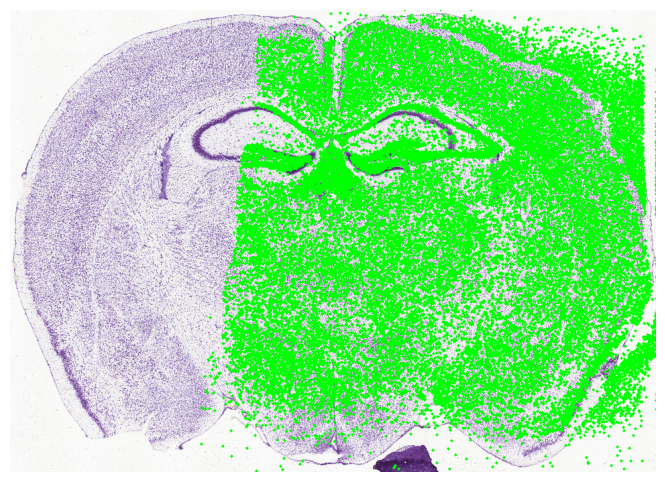


✨✨✨ 所有流程执行完毕！ ✨✨✨


In [8]:
print("\n🚀 步骤四 正在生成彩色叠加对比图...")
# 1. 读取原图（不带 GRAYSCALE 参数，默认读取 BGR 3通道）
target_img = cv2.imread(target_image_path)
# 对齐后的点位图依然读取为灰度，作为掩膜(Mask)使用
aligned_h5ad_img = cv2.imread(transformed_with_ccf_h5ad_img_path, cv2.IMREAD_GRAYSCALE)

if target_img is None or aligned_h5ad_img is None:
    print("❌ 图像读取失败，请检查路径。")
else:
    # 获取尺寸
    t_h, t_w = target_img.shape[:2]
    a_h, a_w = aligned_h5ad_img.shape[:2]
    print(f"📏 Target 尺寸: {t_w}x{t_h} (彩色) | Aligned H5AD 尺寸: {a_w}x{a_h}")

    # 2. 创建匹配 Target 尺寸的掩膜画布
    # 确保即使 H5AD 图像尺寸小，也能准确对齐到左上角
    h5ad_mask_full = np.zeros((t_h, t_w), dtype=np.uint8)
    h_limit = min(t_h, a_h)
    w_limit = min(t_w, a_w)
    h5ad_mask_full[:h_limit, :w_limit] = aligned_h5ad_img[:h_limit, :w_limit]

    # 3. 叠加预览：在原色图上涂色
    # 我们创建一个副本，不破坏原始 target_img
    overlay_img = target_img.copy()

    # 设定一个阈值，h5ad_mask_full 中大于此值的像素被视为“有点”
    point_threshold = 50 
    mask = h5ad_mask_full > point_threshold

    # 将有像素点的地方设为亮绿色 [B, G, R] -> [0, 255, 0]
    overlay_img[mask] = [0, 255, 0] 

    # 5. 保存结果
    overlay_save_path = os.path.join(save_path_alignment_with_ccf, "color_alignment_overlay.png")
    cv2.imwrite(overlay_save_path, overlay_img)
    
    # 同时保存一份原图和叠加图的左右对比
    comparison = np.hstack((target_img, overlay_img))
    cv2.imwrite(os.path.join(save_path_alignment_with_ccf, "color_side_by_side.png"), comparison)
    print(f"✅ 彩色叠加图已保存：{overlay_save_path}")

    # --- 在 Notebook 中显示结果 ---
    
    plt.figure(figsize=(12, 6))
    # cv2 读入是 BGR，matplotlib 需要 RGB
    plt.imshow(cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
print("\n✨✨✨ 所有流程执行完毕！ ✨✨✨")